In [1]:
from itertools import product

In [2]:
from cpa_utils import *

# Elisabeth-b4 - Filter block

## Attacking the filter S-boxes

In [3]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"
locations_path = "correlation_locations_b4_two_last_rounds.pic"

In [4]:
seeds, traces, real_keys, correlation_locations = load_data(traces_path, key_path, locations_path)

In [5]:
def indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(key_target_idx: int, block_target_idx: int, total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    if not (0 <= block_target_idx < BLOCK_WIDTH_B4 - 1):
        return None

    key_space = (16,) if block_target_idx % 2 == 0 else (16, 16)
    location_mask_per_trace = np.zeros(total_traces.shape, dtype=bool)
    hypotheses = np.zeros(key_space + total_seeds.shape, dtype=int)

    if block_target_idx % 2 != 0:
        other_key_target_indices = np.zeros_like(total_seeds, dtype=int)

    for i, iv in enumerate(total_seeds):
        indices, whitening = chacha_random_b4(iv)
        keyround_target_idx = indices.index(key_target_idx)
        if keyround_target_idx < KEYROUND_WIDTH_B4:
            round_idx = keyround_target_idx // BLOCK_WIDTH_B4
            block_idx = keyround_target_idx % BLOCK_WIDTH_B4

            # For now, we only attack even-indexed keyrounds (but not the last one) because they depend on a single key nibble
            # TO REMOVE IF BETTER IDEA IS FOUND
            #if block_idx == BLOCK_WIDTH_B4 - 1 or block_idx % 2 != 0:
            #if round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 or block_idx != 4:
            if (round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 and round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2) or block_idx != block_target_idx:
                continue
            # TO REMOVE IF BETTER IDEA IS FOUND

            if block_idx != BLOCK_WIDTH_B4 - 1:
                if block_idx % 2 == 0:
                    for k in range(16):
                        block = [0] * BLOCK_WIDTH_B4
                        block[block_idx] = (k + whitening[keyround_target_idx]) % 16

                        sbox_in = block[block_idx]
                        sbox_out = s_boxes_b4[block_idx][sbox_in]

                        hypotheses[k][i] = HW[sbox_out]
                else:
                    for k1, k2 in product(range(16), range(16)):
                        block = [0] * BLOCK_WIDTH_B4
                        block[block_idx] = (k1 + whitening[keyround_target_idx]) % 16
                        block[block_idx - 1] = (k2 + whitening[keyround_target_idx - 1]) % 16

                        sbox_in = (block[block_idx] + block[block_idx - 1]) % 16
                        sbox_out = s_boxes_b4[block_idx][sbox_in]
                        
                        hypotheses[k1][k2][i] = HW[sbox_out]
                    other_key_target_indices[i] = indices[keyround_target_idx - 1]
        
                location_mask_per_trace[i][locations[round_idx][block_idx]] = True
            else:
                raise ValueError("Should not happen")
                for i in range(3):
                    block[2*i + 1] = (block[2*i + 1] + block[2*i]) % 16
                y = [s_boxes_b4[i][block[i]] for i in range(BLOCK_WIDTH_B4 - 1)]
                z = [(y[(2*i + 5*j - 1) % (BLOCK_WIDTH_B4 - 1)] + y[2*i + j]) % 16 for i in range(3) for j in range(2)]
                z = [s_boxes_b4[6 + i][(z[i] + block[(i + 2) % (BLOCK_WIDTH_B4 - 1)]) % 16] for i in range(BLOCK_WIDTH_B4 - 1)]
                t_0 = (z[0] + z[1] + z[2]) % 16
                t_0 = (t_0 + block[block_idx - 1]) % 16
                sbox_out = s_boxes_b4[12][t_0]

                hypotheses[i] = HW[(block[block_idx] + sbox_out) % 16]
    
    if block_target_idx % 2 == 0:
        return total_traces[location_mask_per_trace].reshape((-1, locations.shape[2])), hypotheses[..., np.any(location_mask_per_trace, axis=1)]
    else:
        return total_traces[location_mask_per_trace].reshape((-1, locations.shape[2])), hypotheses[..., np.any(location_mask_per_trace, axis=1)], other_key_target_indices

In [6]:
def indices_locations_and_hyps_to_use_for_each_key_nibble(key_target_idx: int, block_target_indices: set[int], total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> List[Tuple[np.ndarray, np.ndarray]]:
    if any([not (0 <= b < BLOCK_WIDTH_B4 - 1) for b in block_target_indices]):
        return None

    return [indices_locations_and_hyps_to_use_for_each_key_nibble_specific_block_idx(key_target_idx, b, total_seeds, total_traces, locations) for b in block_target_indices]

Key 0: 

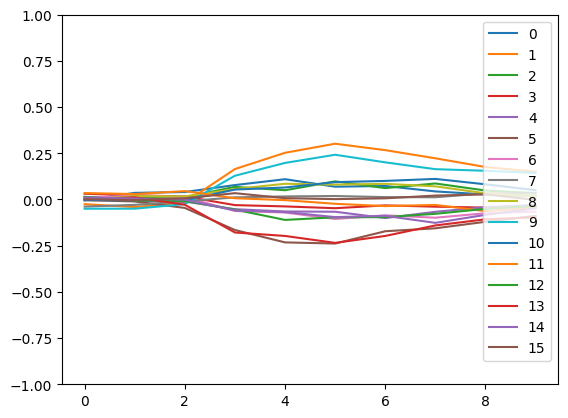

1[ 0.10960496  0.30169521  0.0980122   0.03098991  0.01305762 -0.00370739
  0.0223105   0.03311447  0.08503595  0.24201271  0.11129552  0.04535318
  0.01433394  0.0117986   0.01033939  0.03409246]


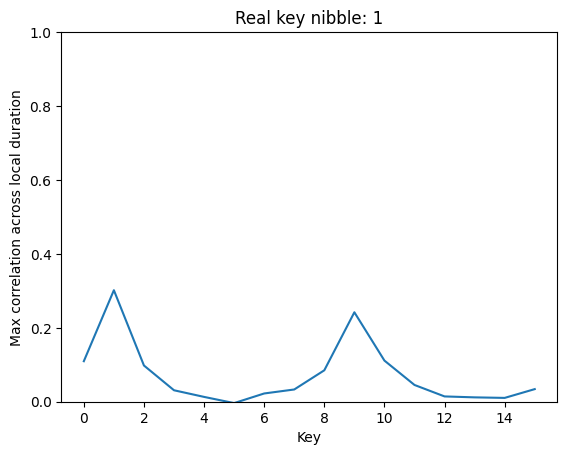

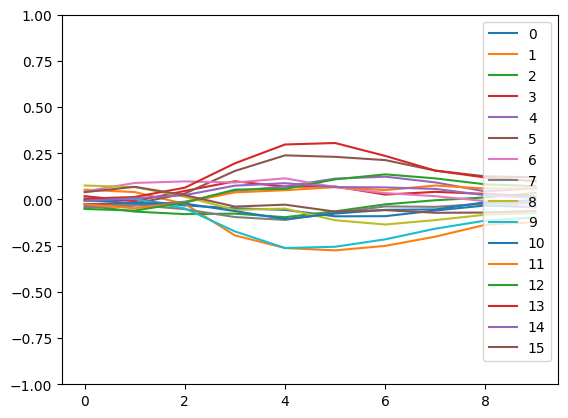

D[-0.00265111  0.05307226  0.0351219   0.0984216   0.12333685  0.23879073
  0.11441979 -0.0180418   0.07553938  0.00420295 -0.00381275  0.07554809
  0.13591009  0.30555221  0.08804267  0.06846279]


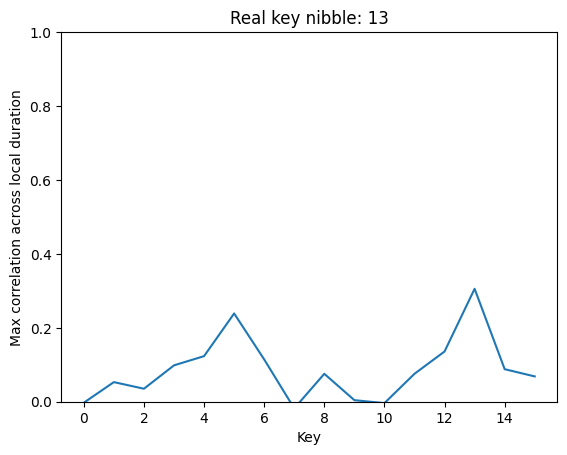

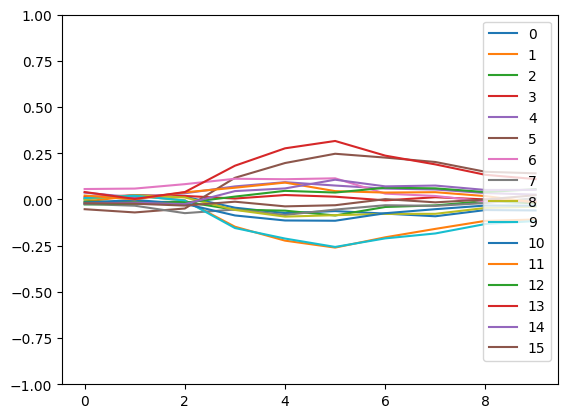

D[ 0.02254088  0.01994546 -0.0086752   0.02411288  0.09363553  0.24740633
  0.11449524  0.0074048   0.02231373  0.02002646 -0.00248637  0.09141479
  0.06339949  0.31657943  0.1069801   0.02326083]


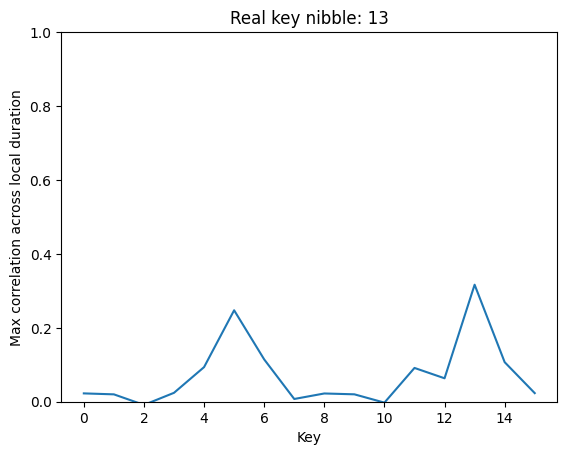

KeyboardInterrupt: 

In [12]:
reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ", end="")
    visited = set()
    for j in range(reconstructed_keys.shape[1]):
        block_targets = [4]
        locs_and_hyps_per_block_target = indices_locations_and_hyps_to_use_for_each_key_nibble(j, block_targets, seeds[i], traces[i], correlation_locations)
        for k, block in enumerate(block_targets):
            if block % 2 == 0:
                selected_traces, hypotheses = locs_and_hyps_per_block_target[k]
                corrs = np.array([corr_coef_vectorized(hypotheses[l], selected_traces) for l in range(hypotheses.shape[0])])
            else:
                selected_traces, hypotheses, other_key_indices = locs_and_hyps_per_block_target[k]
                corrs = np.max([[corr_coef_vectorized(hypotheses[k1][k2], selected_traces) for k2 in range(hypotheses.shape[1])] for k1 in range(hypotheses.shape[0])], axis=1)

            for l in range(len(corrs)):
                plt.plot(corrs[l], label=str(l))

            plt.ylim([-1, 1])
            plt.legend()
            plt.show()
            
            max_corrs = np.max(corrs, axis=1)
            best_k = np.argmax(max_corrs)
            reconstructed_keys[i][j] = best_k

            if block % 2 != 0:
                pass
                #reconstructed_keys[i][other_key_indices[]]

            print(hex(best_k)[2:].upper(), end="")

            print(max_corrs)
            plt.plot(max_corrs)
            plt.xlabel("Key")
            plt.ylabel("Max correlation across local duration")
            plt.title(f"Real key nibble: {real_keys[i][j]}")
            plt.ylim([0, 1])
            plt.show()
    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()

## Try with less traces

Key 0: 1[ 0.0418281   0.30457182  0.14237257  0.08361911  0.09614659 -0.03355997
  0.03555159  0.04841252  0.09669427  0.26996128  0.11223129  0.15562314
  0.02559493  0.01784403  0.01970175  0.07476165]


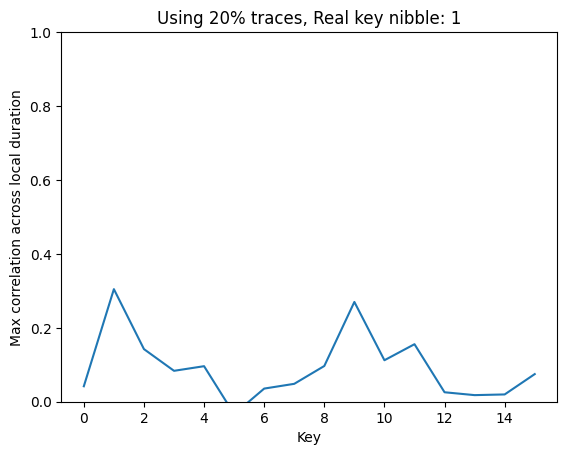

1[ 0.11754869  0.27812229  0.15211488  0.02273203  0.08746082 -0.0392471
 -0.01319143  0.02559545  0.11566068  0.25038507  0.09641616  0.10379825
  0.04257146 -0.01436211 -0.00285893  0.08021816]


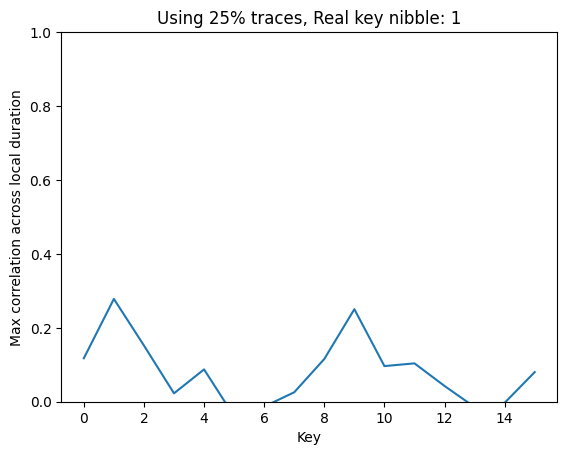

1[ 0.10800537  0.28346471  0.15045995  0.03029525  0.08207383 -0.04437351
  0.02313005  0.01909358  0.13450378  0.22822789  0.10447055  0.12128275
  0.02636672  0.00520399  0.01301245  0.05195454]


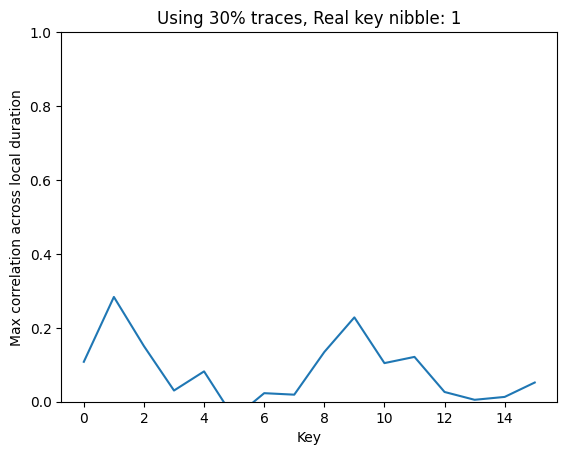

1[ 0.10342808  0.3038621   0.18148062  0.02216657  0.08836518 -0.01028786
  0.01737246  0.01847448  0.09706677  0.26265655  0.14344139  0.10091199
  0.0068331   0.02192743  0.02030115  0.03796813]


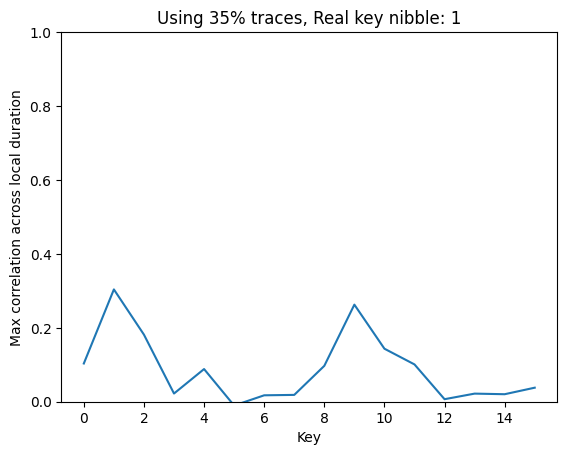

1[ 0.11419175  0.2941404   0.1489097   0.0291183   0.08412453 -0.00214748
  0.00290337  0.02390213  0.10562531  0.26974182  0.13046214  0.09013781
  0.02281547  0.02205856  0.01829853  0.04410045]


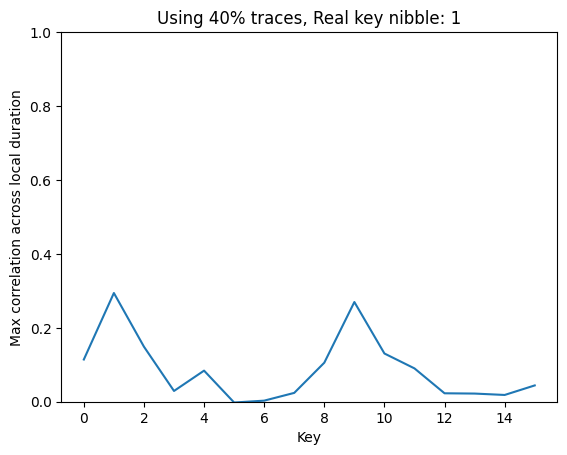

5[0.07261578 0.04101065 0.14443529 0.23624793 0.27287778 0.3389026
 0.21090742 0.08017087 0.07323411 0.07186866 0.07695781 0.1917713
 0.27973061 0.32055524 0.14052953 0.1778667 ]


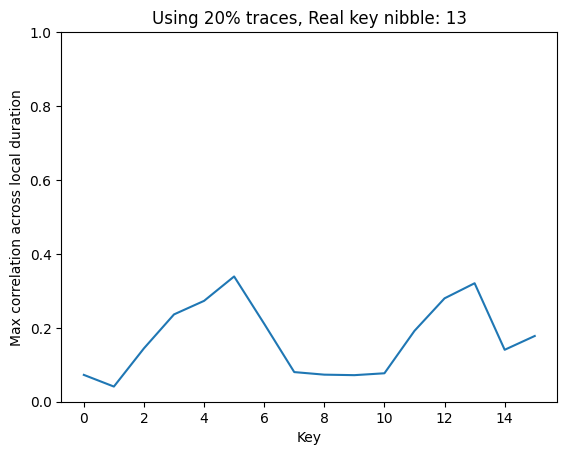

5[0.02468541 0.08011745 0.12491101 0.1702492  0.2504079  0.32619942
 0.17480595 0.02036943 0.07669145 0.06095241 0.04934851 0.15418957
 0.20703652 0.31560192 0.11525543 0.14436189]


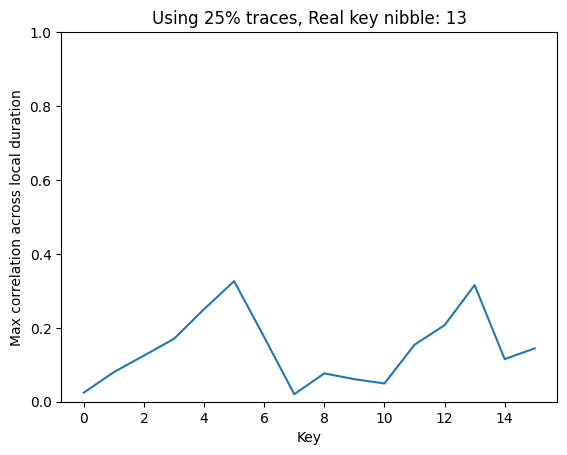

D[-0.00363454  0.03524651  0.08368894  0.13488304  0.18919665  0.29946573
  0.19013801 -0.00529679  0.05493148  0.05742007  0.05277233  0.14766693
  0.17262705  0.32148502  0.09729218  0.09360701]


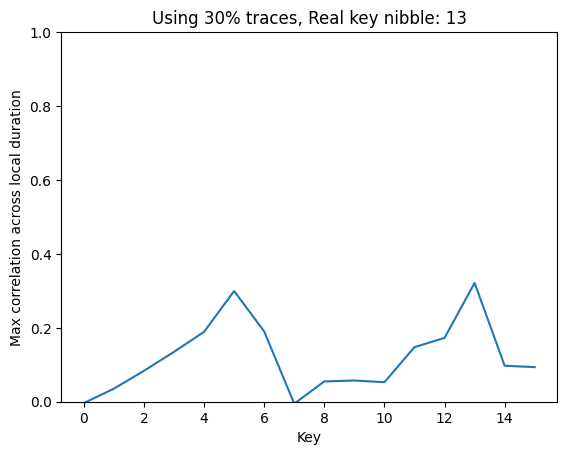

D[-0.02495175  0.03550381  0.06885943  0.15050368  0.17826846  0.27369601
  0.20432212  0.02494586  0.05260918  0.05325866  0.03050949  0.13060576
  0.16767318  0.31403957  0.10990443  0.0614676 ]


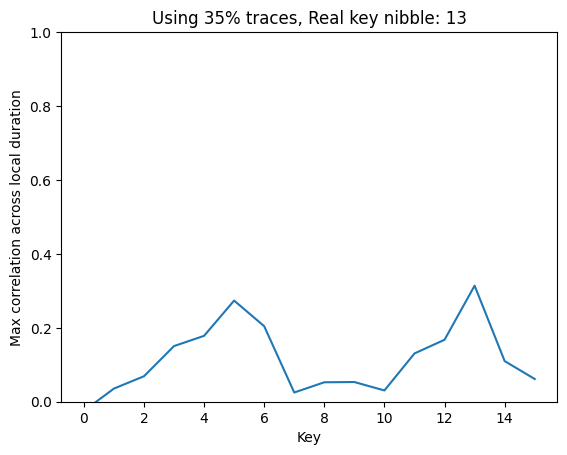

D[-0.0227958   0.00907256  0.08320989  0.13785922  0.18538139  0.26258748
  0.1849847   0.01057232  0.07582163  0.01462111  0.04521517  0.09532125
  0.16924748  0.27703215  0.10078541  0.08187763]


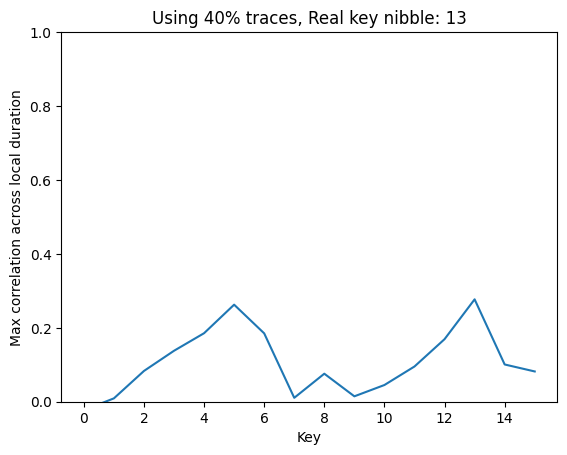

5[0.00685285 0.14413043 0.0654698  0.06561616 0.09247198 0.25154832
 0.1966191  0.11412609 0.07112891 0.16166886 0.03110675 0.09119793
 0.06848589 0.23513263 0.12956302 0.1050501 ]


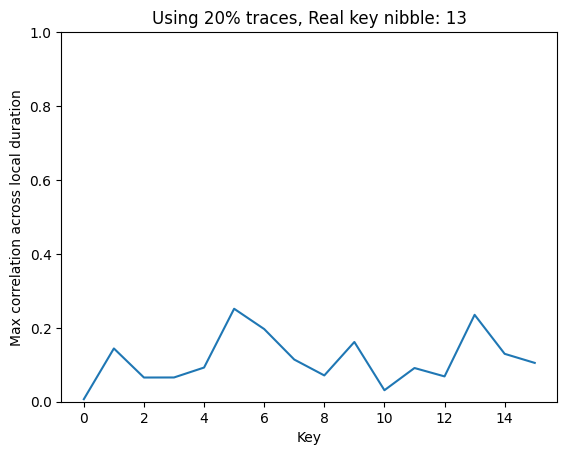

D[-0.00773047  0.06381642  0.09260078  0.02861666  0.10687167  0.24111308
  0.21360075  0.07960032  0.02446183  0.09762503  0.04983413  0.0523851
  0.0706949   0.26387187  0.08807971  0.06406783]


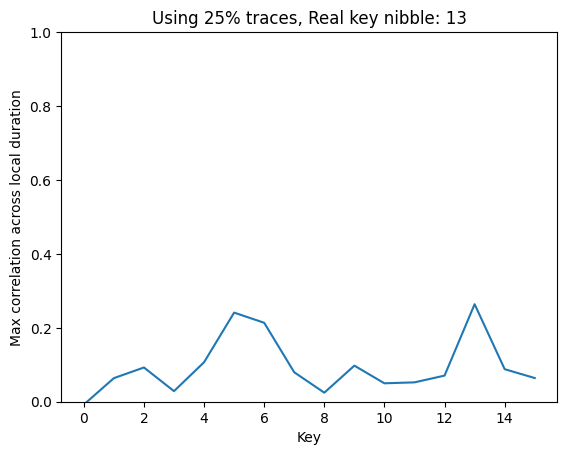

D[-0.01584375  0.04325033  0.07229117  0.02611062  0.15422298  0.22372655
  0.2267054   0.06986442  0.00914295  0.04908885  0.05040027  0.09564581
  0.07512875  0.29151838  0.0780373   0.07299672]


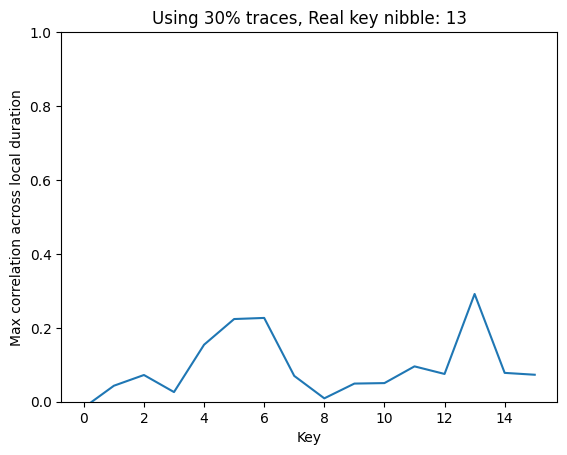

D[0.02159268 0.03454382 0.03282575 0.05008141 0.12147252 0.20331447
 0.16596959 0.06956111 0.02627143 0.0508864  0.00447652 0.12335899
 0.09706603 0.27389458 0.10347811 0.06615267]


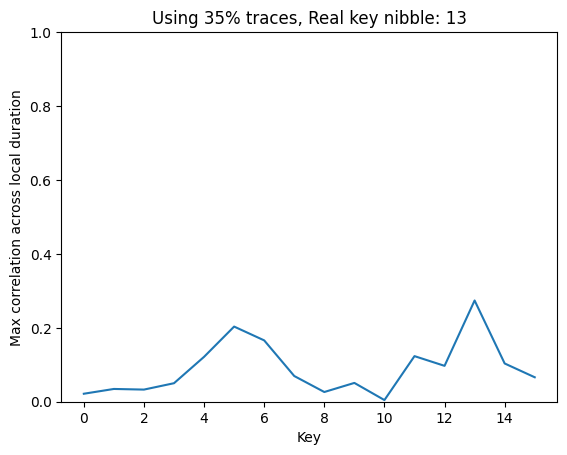

D[0.0021475  0.02473358 0.00313286 0.06252013 0.13507138 0.21661609
 0.18007007 0.05667541 0.00870921 0.0566335  0.00275022 0.11487824
 0.08587987 0.29152464 0.1018339  0.03341939]


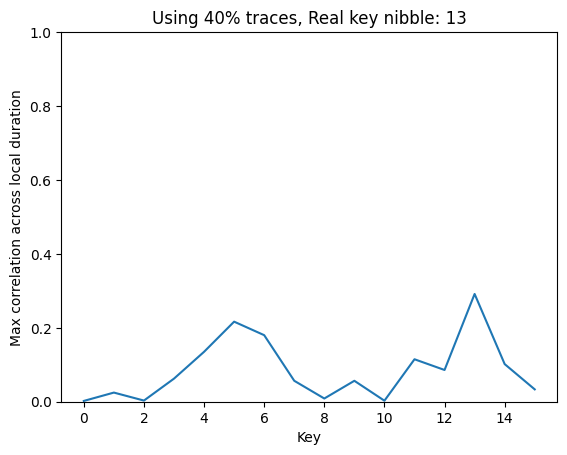

4[0.01412043 0.12242973 0.11190541 0.10853235 0.35393927 0.04704501
 0.04201286 0.03823834 0.09419909 0.08761119 0.13020963 0.07063295
 0.27253966 0.07804233 0.02296099 0.01002632]


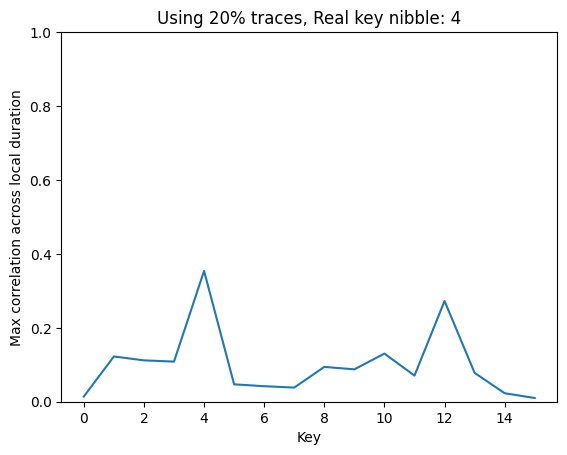

4[-0.01668295  0.07421816  0.07150098  0.08387831  0.30907878  0.07118974
  0.03103636  0.01827663  0.03497148  0.09078614  0.10003048  0.08052718
  0.2691955   0.06362435  0.04278837  0.02388624]


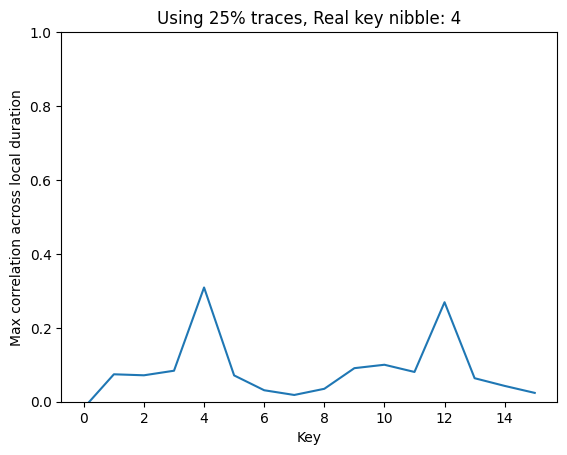

4[0.00631822 0.06835157 0.08953298 0.05699291 0.34648531 0.07753309
 0.02777145 0.01363255 0.07962359 0.07805086 0.0920749  0.09190566
 0.25533683 0.09121035 0.05468144 0.06331815]


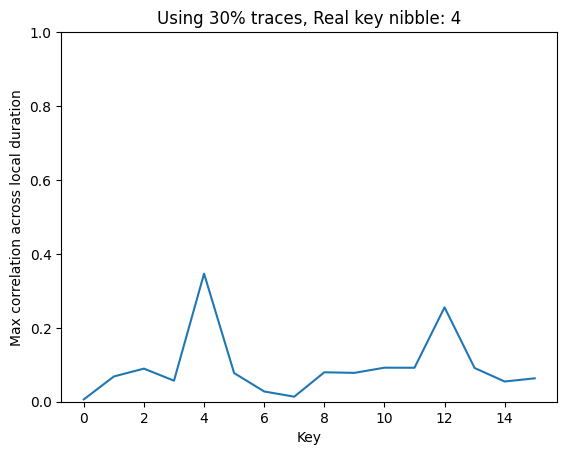

4[ 0.02166662  0.05608412  0.07795781  0.06530237  0.35691329  0.07697228
  0.03605325 -0.00988028  0.0799659   0.05186768  0.08373905  0.11176683
  0.24975708  0.1108158   0.04881717  0.07111373]


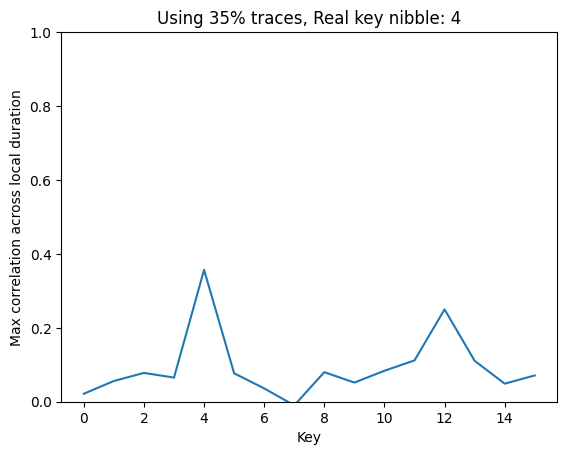

4[0.02666968 0.01826596 0.05734238 0.06343364 0.32532863 0.08829237
 0.043551   0.0017617  0.06271938 0.04789264 0.07447546 0.08898317
 0.24046355 0.10961667 0.07766742 0.02238112]


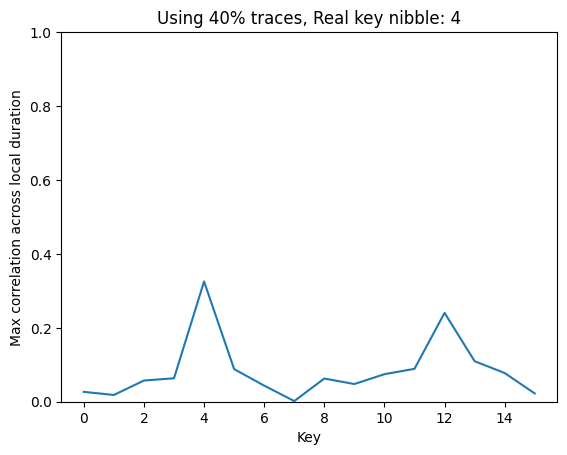

E[ 0.0561689  -0.00311662  0.01532086  0.18994309  0.04015805  0.17493526
  0.20931416  0.16081109  0.06495615  0.02868042  0.0940429   0.0805477
  0.08216914  0.07866926  0.31102881  0.14439724]


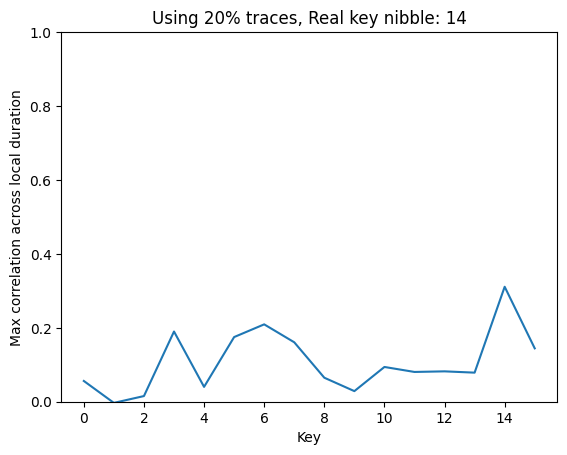

E[ 0.09006188 -0.00646869  0.01823446  0.14982033  0.06913996  0.15261869
  0.17207021  0.20023303  0.09457201  0.01556919  0.07775353  0.09649276
  0.09156748  0.07866518  0.26471643  0.15876257]


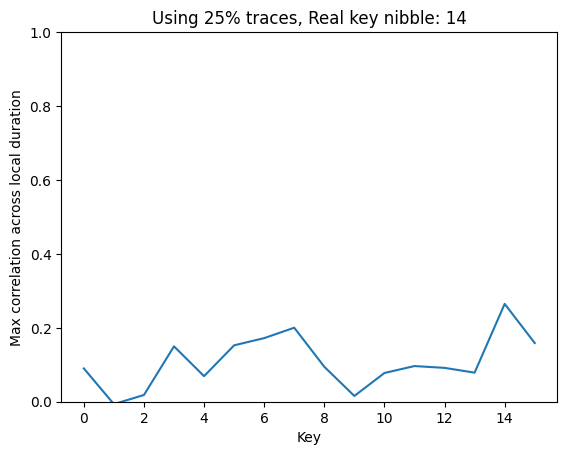

E[0.06300481 0.05068664 0.06715116 0.10711246 0.05707953 0.22046825
 0.22036655 0.1450808  0.0872921  0.02536148 0.11530295 0.07583774
 0.05517035 0.12131331 0.30941422 0.12645006]


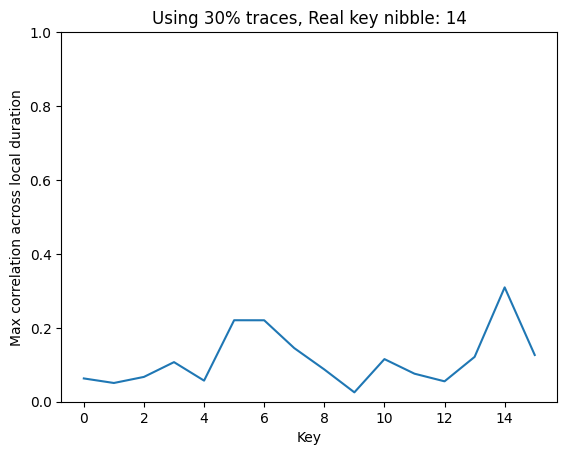

E[0.09737726 0.0294583  0.03685442 0.09319692 0.01499276 0.2123561
 0.20518757 0.14098004 0.07135195 0.00068262 0.08059603 0.05518338
 0.03288506 0.12059359 0.27886767 0.13298404]


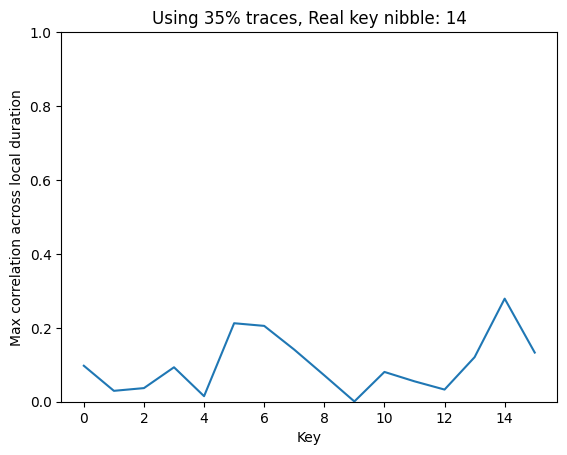

E[ 0.08453722 -0.00410727  0.01491542  0.10921819  0.02577698  0.1690879
  0.20379102  0.14236951  0.05363268  0.02874722  0.05292546  0.07596667
  0.04684918  0.11479153  0.28616232  0.14692141]


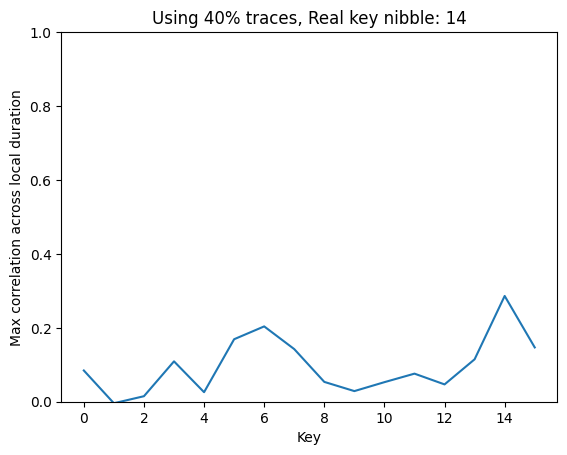

9[0.1972947  0.15057319 0.18658155 0.03544979 0.08897068 0.05234868
 0.06263115 0.08151724 0.15801585 0.3802295  0.06539763 0.10376511
 0.15948826 0.00880536 0.05823653 0.06569232]


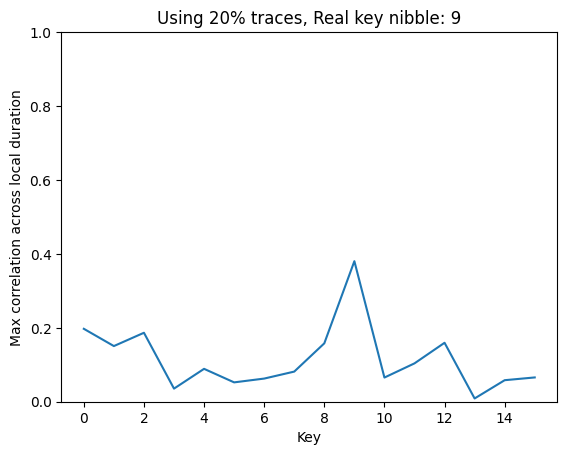

9[0.18853685 0.19103485 0.17643891 0.06989146 0.08455048 0.07607036
 0.06375575 0.06502617 0.18414237 0.38134268 0.12598909 0.06631073
 0.17027218 0.06332115 0.04152076 0.07493704]


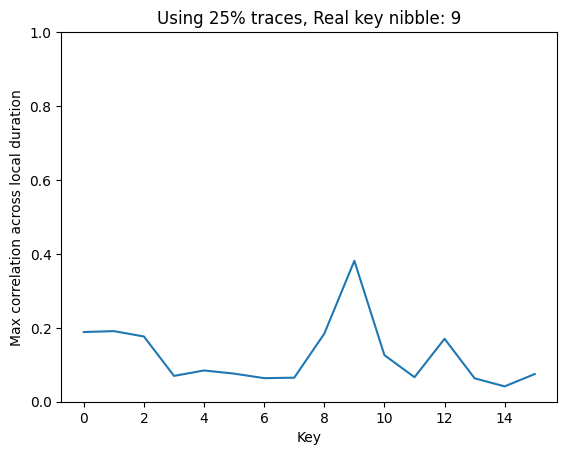

9[0.18238479 0.20299533 0.18051896 0.01691048 0.11705915 0.07359016
 0.10477908 0.06734016 0.1661708  0.35825367 0.14957257 0.07531042
 0.14267198 0.07368746 0.0392113  0.02366169]


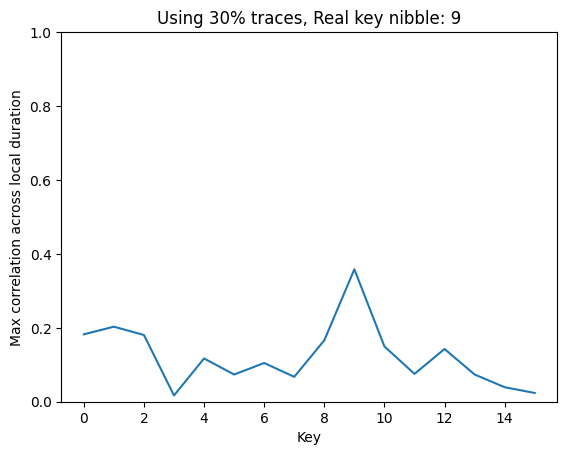

9[0.17022192 0.20692601 0.16912824 0.03467613 0.06533234 0.05637825
 0.11196487 0.04015711 0.12947408 0.36305563 0.12538998 0.07389616
 0.12525836 0.05069453 0.02681758 0.04195722]


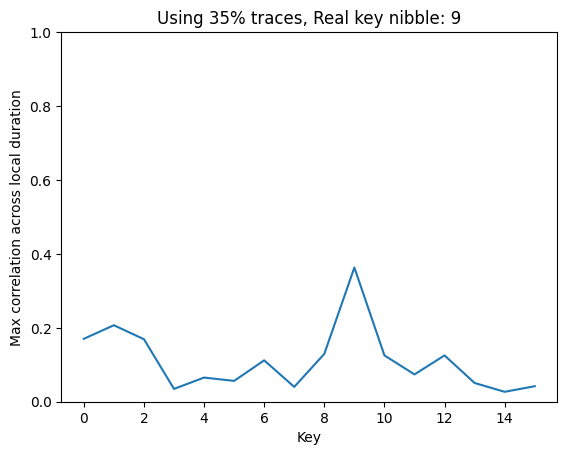

9[0.1533861  0.23068356 0.15465367 0.0234975  0.07291684 0.05833156
 0.12512781 0.06323287 0.12544133 0.361591   0.11646832 0.05728162
 0.13752595 0.07424955 0.02660869 0.04227334]


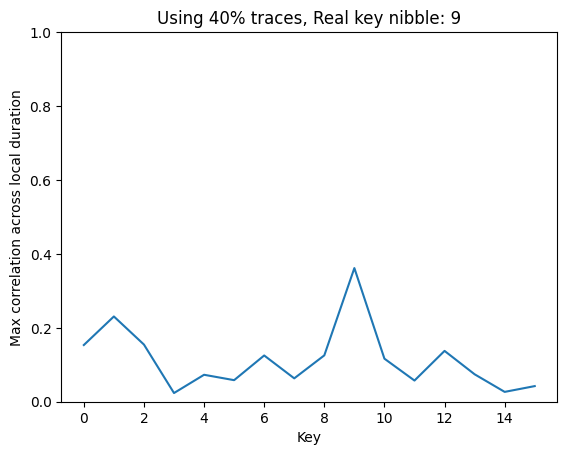

1[0.23287632 0.3201648  0.16350186 0.08112318 0.05560853 0.11965437
 0.057702   0.07267226 0.20888918 0.28649639 0.22207383 0.04215352
 0.04837281 0.08316794 0.05211531 0.02508353]


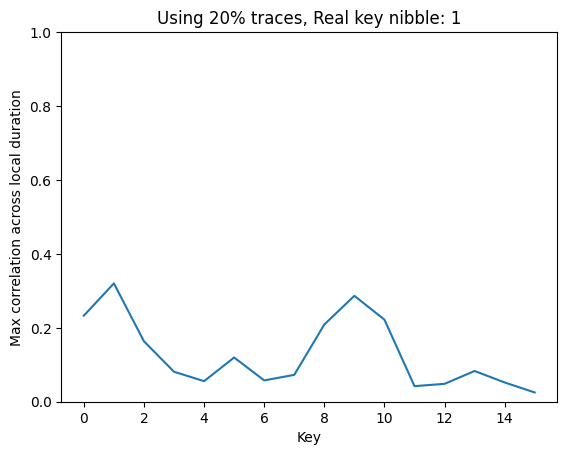

1[0.18301035 0.31116896 0.11136791 0.02994628 0.04607036 0.04999475
 0.06256977 0.07025281 0.18119971 0.24081245 0.15697764 0.06095811
 0.03927481 0.02923247 0.00466942 0.04139035]


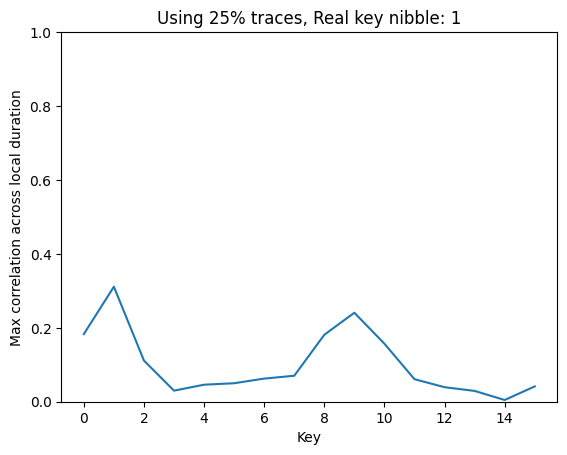

1[0.14666079 0.30809271 0.12490778 0.04447288 0.0310965  0.00764728
 0.0545672  0.04269498 0.13219653 0.24488909 0.14317573 0.01941967
 0.03689742 0.00267774 0.01772597 0.01423023]


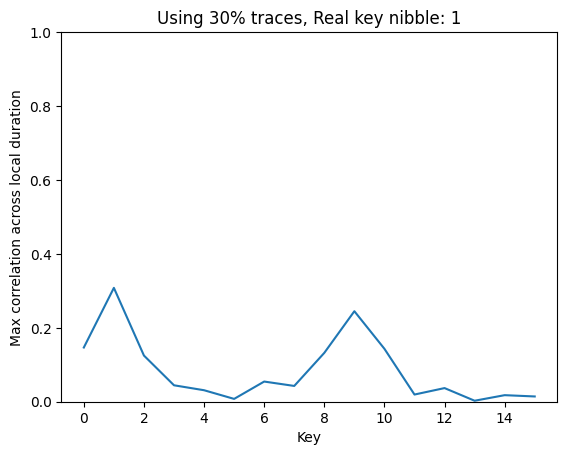

1[ 0.15434302  0.31034449  0.1081061   0.01766426  0.0165312   0.00927545
  0.0532958   0.04463584  0.14372757  0.23497684  0.14979798  0.01443839
  0.03582894 -0.0136756   0.04706605  0.05040836]


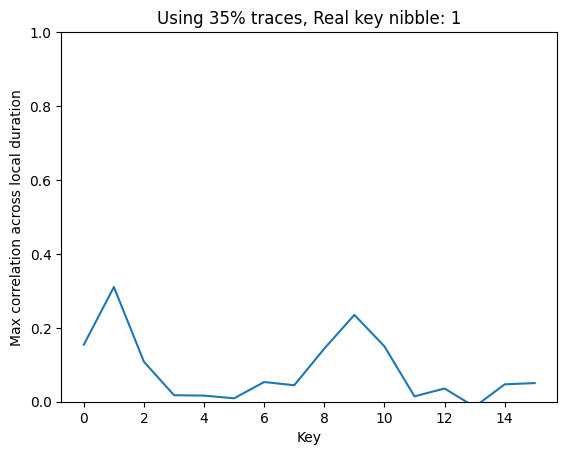

1[ 0.1202941   0.31755273  0.10120348  0.03694689  0.01410244 -0.00329819
  0.04893533  0.05524143  0.13493654  0.23852925  0.13519528  0.03741944
  0.03588954 -0.01498234  0.03477042  0.06394419]


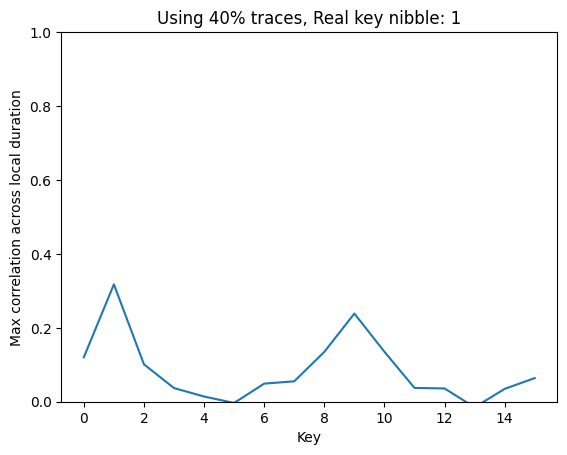

F[ 0.20398214  0.07349932  0.01109393  0.04213489  0.03280556  0.02119064
  0.08330951  0.22434372  0.12477718  0.06661038  0.01750385 -0.03687908
  0.13002928  0.10152897  0.14271074  0.29481671]


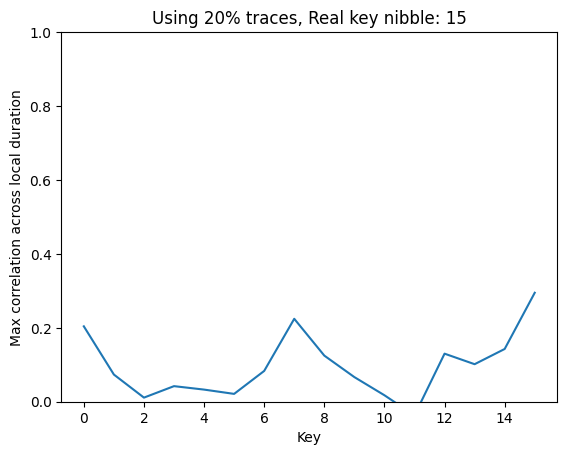

F[ 0.14056331  0.03970098 -0.00408674  0.03253225  0.02701684  0.05620698
  0.10239921  0.25337904  0.05543238  0.05885988  0.01550483 -0.0172626
  0.09628606  0.10500581  0.09377726  0.29603561]


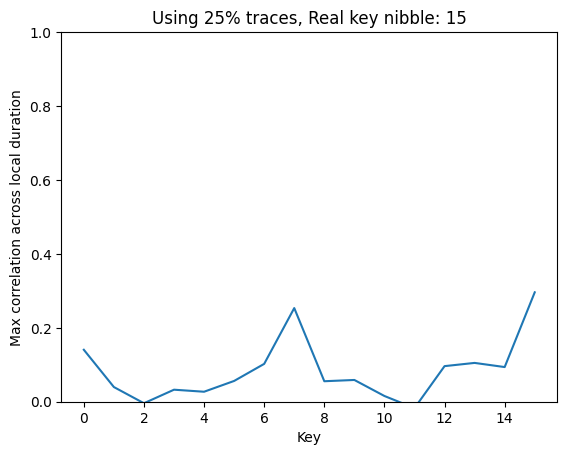

F[ 0.13116595  0.04730039 -0.0092639  -0.00100516  0.0312543   0.02324983
  0.11278001  0.27805156  0.11039166  0.0304397   0.03166692  0.01191121
  0.07192357  0.10554803  0.0946831   0.30723313]


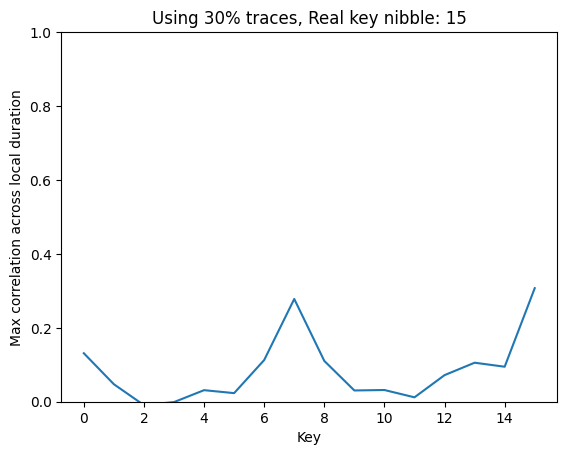

F[ 0.1164847   0.04078544 -0.02260402 -0.03068864  0.03385487  0.02572851
  0.10058427  0.28136812  0.09025076  0.03430597  0.00688365  0.00571162
  0.02587712  0.10012093  0.10277273  0.34089481]


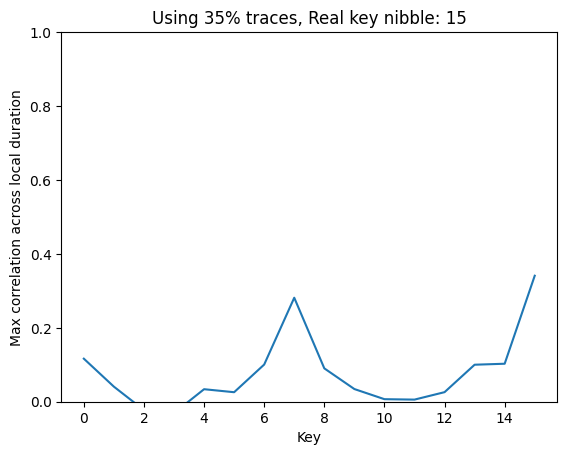

F[ 0.10516773  0.04213595  0.02376291 -0.02397539  0.03869569  0.02205409
  0.13175157  0.26960317  0.06637051  0.05284865  0.00480414  0.02059174
  0.03189874  0.08294477  0.08537642  0.3325276 ]


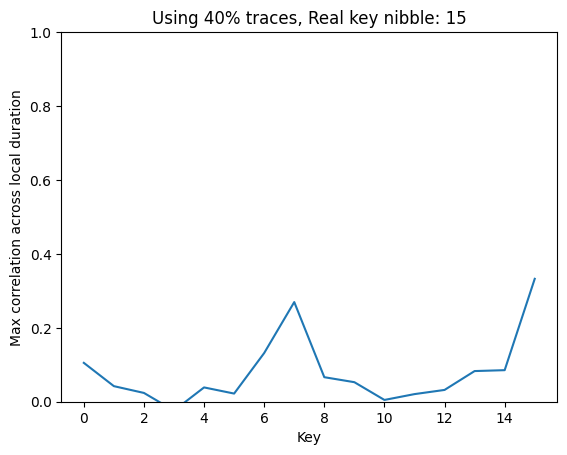

8[0.21470118 0.20439474 0.08465162 0.01386423 0.10326271 0.12208515
 0.07610464 0.08766969 0.24365808 0.17251573 0.11737683 0.0536817
 0.03724456 0.03758498 0.11432866 0.12867166]


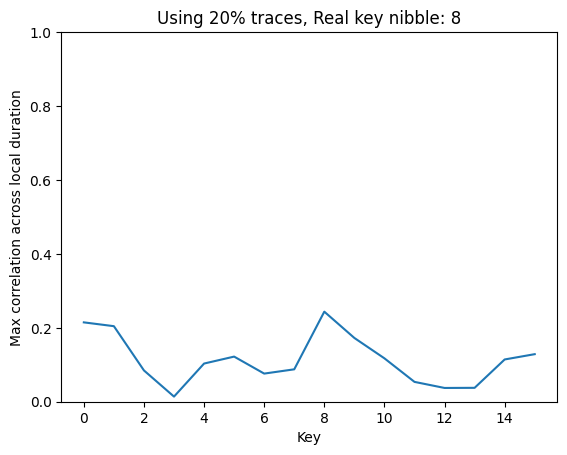

8[ 0.25216847  0.14545089  0.06969424 -0.02200479  0.05276238  0.07256606
  0.08418351  0.06660904  0.28638766  0.13416044  0.14031581  0.06391608
 -0.00366628  0.01822207  0.10418078  0.09847238]


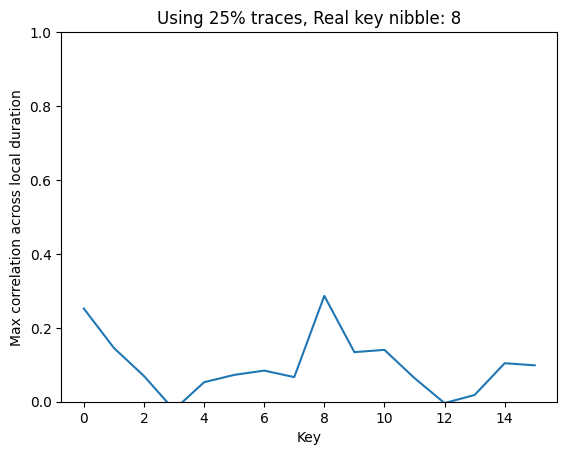

8[ 0.23780141  0.13879942  0.04687074 -0.00443892  0.07220976  0.06345851
  0.09642098  0.07562483  0.31043377  0.11772353  0.10222336  0.06126626
 -0.03727919  0.03593716  0.11071676  0.13326143]


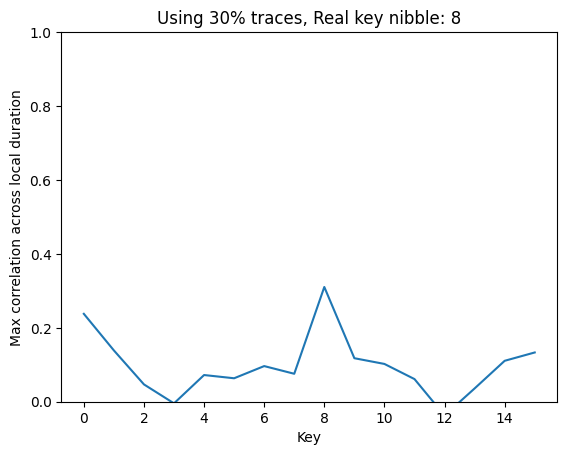

8[ 0.25259773  0.156544    0.02898453 -0.00601377  0.07563175  0.04056915
  0.12140138  0.07687463  0.33763181  0.13111417  0.08397052  0.05005292
 -0.02287193  0.0312344   0.09646757  0.09461064]


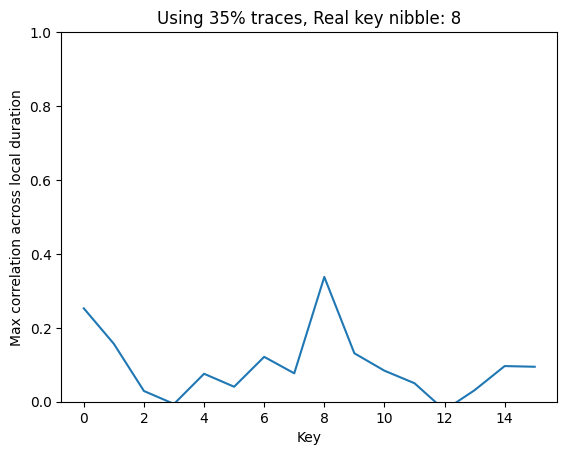

8[ 0.27914795  0.15501308  0.00954591 -0.00957623  0.07827093  0.06853281
  0.10067755  0.07909927  0.36305588  0.12086     0.07445243  0.07497392
 -0.02638793  0.03533007  0.09486151  0.09920843]


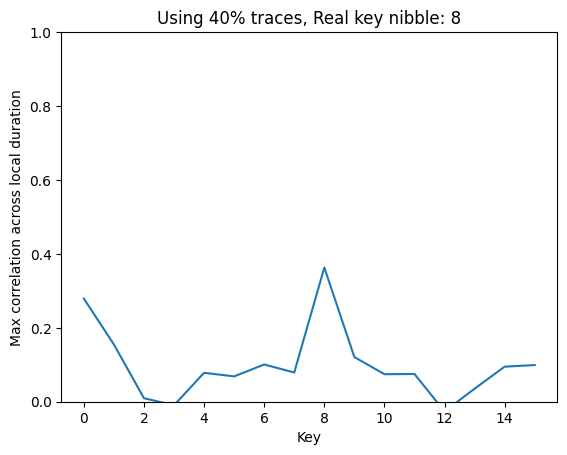

1[0.18396052 0.33538663 0.0985999  0.02838501 0.00826375 0.12835936
 0.02944733 0.15887159 0.16110925 0.26217909 0.20173073 0.07501691
 0.02981158 0.12349489 0.10875359 0.14155268]


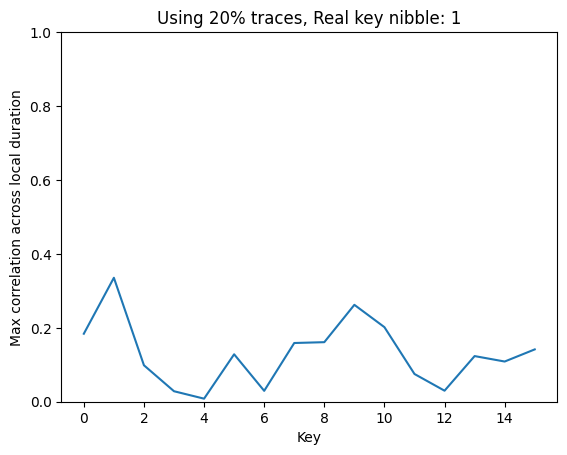

1[0.15599698 0.33026443 0.08714682 0.03128743 0.03570281 0.09800242
 0.04530081 0.11887498 0.17074583 0.28051357 0.13025997 0.08059987
 0.01911172 0.102519   0.02614352 0.11545063]


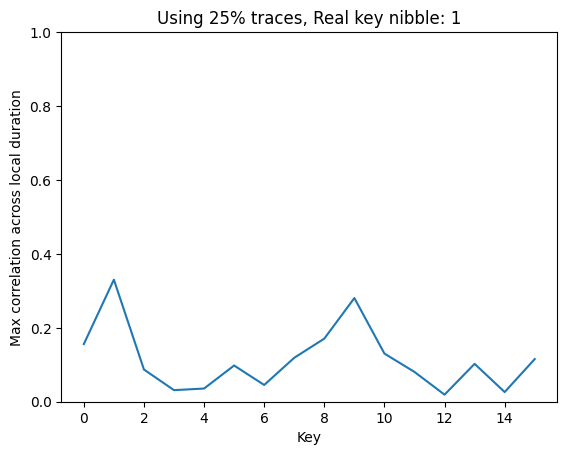

1[ 0.12586705  0.2972213   0.09596479  0.02686744  0.00496525  0.05386225
 -0.01161511  0.14064187  0.12088444  0.26419331  0.14959964  0.03711523
  0.02139739  0.07474905  0.02817843  0.08765078]


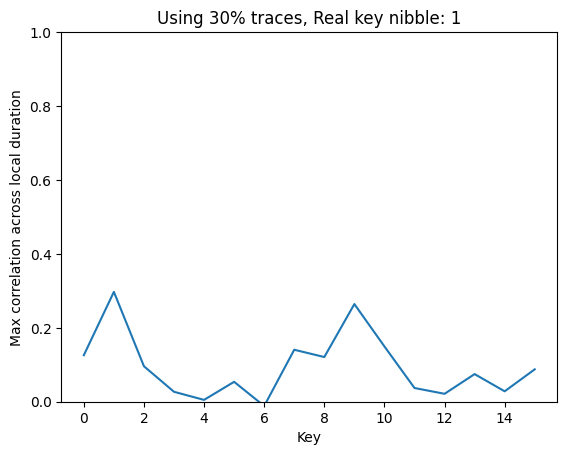

1[ 0.12980308  0.27127818  0.09568792  0.04823735  0.04626495  0.03649641
 -0.02903868  0.13060407  0.10747053  0.26558401  0.15515592  0.03597415
  0.05778287  0.06568663  0.01038836  0.08938008]


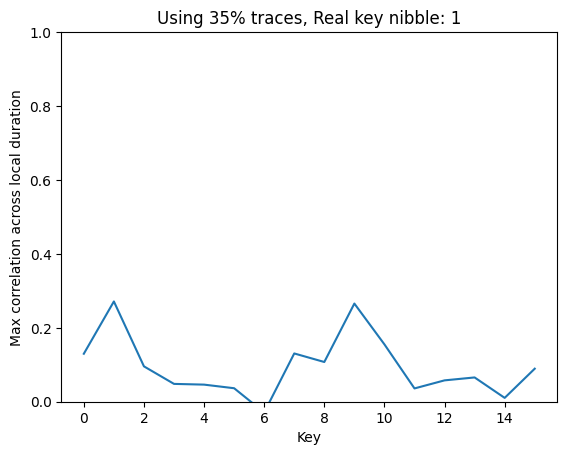

1[0.11325271 0.28400447 0.08661399 0.05706241 0.02924205 0.06235685
 0.00118776 0.13402826 0.10729556 0.26215237 0.15172834 0.03402451
 0.04604887 0.05271475 0.01319974 0.08249226]


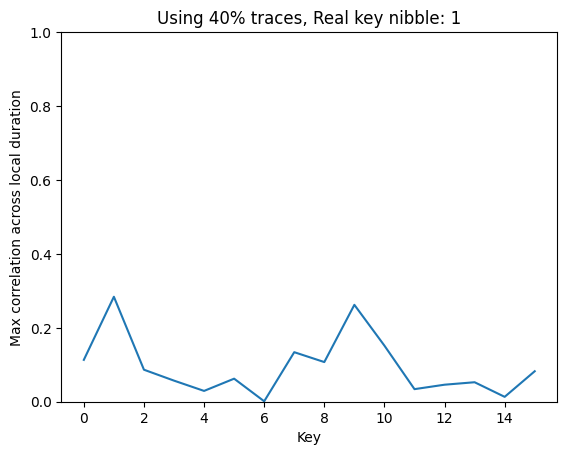

0[ 0.40930713  0.16661116  0.00579204  0.08791499  0.04602732  0.08045241
  0.12282369  0.25331441  0.29157672  0.14558074  0.11349115  0.17555856
 -0.00220028  0.1477779   0.10977669  0.14359286]


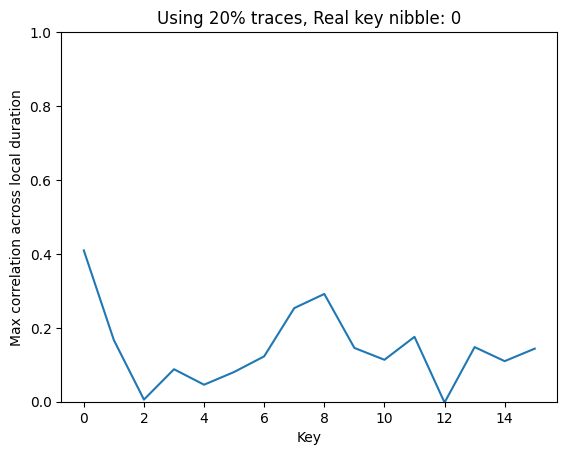

0[0.41645882 0.13421396 0.00945355 0.06615588 0.06766363 0.03996742
 0.10064218 0.22076038 0.2807862  0.15085539 0.07228452 0.13358012
 0.02743667 0.10633478 0.10673191 0.14129651]


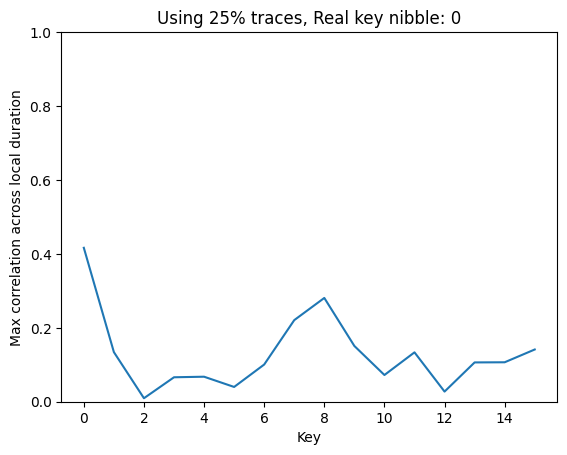

0[0.36499949 0.14597745 0.0440095  0.05950967 0.12371528 0.02138927
 0.08291057 0.19447571 0.27147767 0.13886714 0.05999486 0.13226853
 0.05005789 0.15169593 0.09956753 0.13240771]


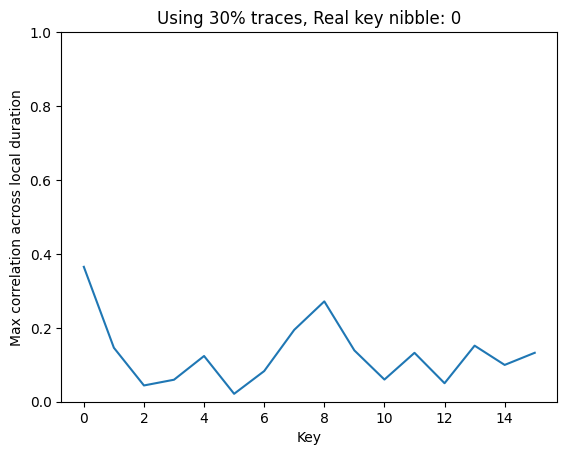

0[0.37015923 0.1215084  0.01487198 0.03597413 0.10938776 0.00974345
 0.06328826 0.18233729 0.24646534 0.15183792 0.03012704 0.10244893
 0.05966046 0.12583314 0.10718885 0.09902006]


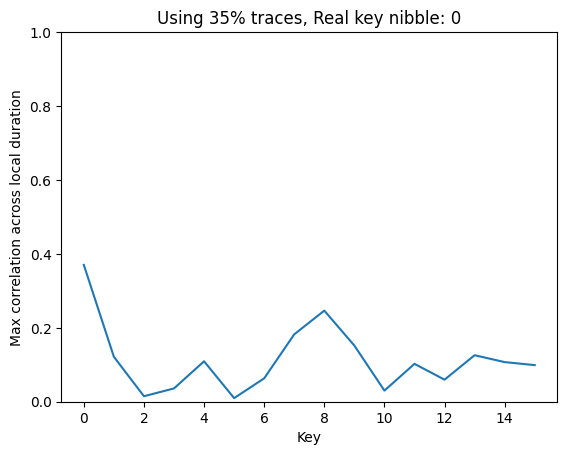

0[ 0.34439463  0.10958815  0.01815001  0.05004348  0.11557658 -0.00741925
  0.04367291  0.18086139  0.24961054  0.13364406  0.0396672   0.11745368
  0.04651964  0.08888414  0.09589998  0.10225448]


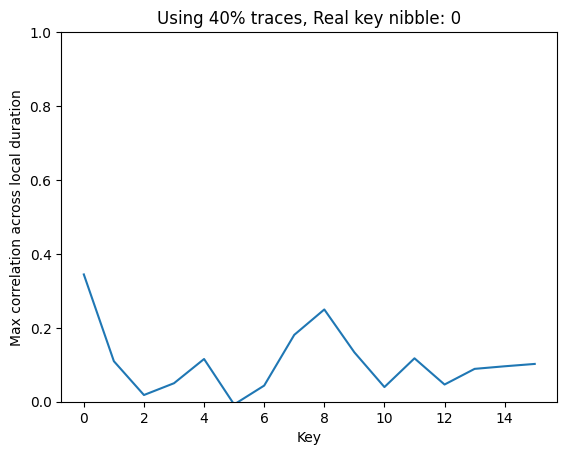

KeyboardInterrupt: 

In [18]:
reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ", end="")
    visited = set()
    for j in range(reconstructed_keys.shape[1]):
        block_targets = [4]
        locs_and_hyps_per_block_target = indices_locations_and_hyps_to_use_for_each_key_nibble(j, block_targets, seeds[i], traces[i], correlation_locations)
        for prop_traces in [x / 100 for x in range(20, 41, 5)]:
            for k, block in enumerate(block_targets):
                if block % 2 == 0:
                    selected_traces, hypotheses = locs_and_hyps_per_block_target[k]
                    corrs = np.array([corr_coef_vectorized(hypotheses[l][:int(prop_traces*len(hypotheses[l]))], selected_traces[:int(prop_traces*len(selected_traces))]) for l in range(hypotheses.shape[0])])
                else:
                    selected_traces, hypotheses, other_key_indices = locs_and_hyps_per_block_target[k]
                    corrs = np.max([[corr_coef_vectorized(hypotheses[k1][k2][:int(prop_traces*len(hypotheses[k1][k2]))], selected_traces[:int(prop_traces*len(selected_traces))]) for k2 in range(hypotheses.shape[1])] for k1 in range(hypotheses.shape[0])], axis=1)
                
                max_corrs = np.max(corrs, axis=1)
                best_k = np.argmax(max_corrs)
                reconstructed_keys[i][j] = best_k

                if block % 2 != 0:
                    pass
                    #reconstructed_keys[i][other_key_indices[]]

                print(hex(best_k)[2:].upper(), end="")

                print(max_corrs)
                plt.plot(max_corrs)
                plt.xlabel("Key")
                plt.ylabel("Max correlation across local duration")
                plt.title(f"Using {prop_traces:.0%} traces, Real key nibble: {real_keys[i][j]}")
                plt.ylim([0, 1])
                plt.show()
    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()

Using only 30% of the traces seems to be enough to get back the key. Note that we attack two s-boxes per trace, so we would need to attack about 30% * 256'000 * 2 = 153'600 s-boxes to get the whole key. This is equivalent to needing 153'600/512 = 300 traces per nibble hypothesis.

If we had used all the 14 rounds, we would need to gather 153'600 / 14 = 10'972 traces.